# TERRA Colocolizes to Double Stranded Breaks (DSBs), esp. in G2
    This project is the data analysis of Dr. Taghreed Mohammed Al Turki's PhD data, in continuation of Chris Nelson's(?) previous work. The objective is to eelucidate if TERRA locolizes to global DSBs, to telomeric DSB's, and which phase of the cell cycle does TERRA colocolize to telo DSBs. 


In [1]:
# handling data
import pandas as pd
import numpy as np

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
import statsmodels.api as sm
import statsmodels.imputation.mice as smi
import scipy.cluster.hierarchy as hac
import matplotlib.gridspec as gridspec
import math
import random

#SHAP Value Stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

print("Setup Complete")

Setup Complete


In [2]:
pwd

'/Users/aidanlew'

In [3]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [4]:
pwd

'/Users/aidanlew/Documents'

# Setting up the data
    We want the data to be read by the program environment so that we can run quick and accurate analysis further on.

In [5]:
### REMEBER TO SAVE AS CSV FOR GITHUB ###

#Data for Global DSB analyis
global_df = pd.read_excel('../Documents/global_DSB_TERRA.xlsx',
                    sheet_name=0,
                    skiprows = 0,
                    usecols = ['foci#_TERRA_with_2Gy ', 'TERRA_foci#/cell_with_0Gy_(control)',
       'foci#_TERRA_2Gy_+RnaseA+H', 'foci#_TERRA_0Gy_+RnaseA+H'] #Mind the space in first column name
                         )

global_df.set_index(['foci#_TERRA_with_2Gy '])#good way to fix "not in axis issue"
global_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#global_df.columns() #Fr some reason not setting the index to the columnn name
global_df.head()



,foci#_TERRA_with_2Gy,TERRA_foci#/cell_with_0Gy_(control),foci#_TERRA_2Gy_+RnaseA+H,foci#_TERRA_0Gy_+RnaseA+H
0,14,2,1.0,8
1,24,2,0.0,5
2,19,1,3.0,5
3,43,0,1.0,8
4,17,11,1.0,6


In [6]:
#Data for telo DSB analyis
telo_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=5,
                    skiprows = 0,
                    usecols = ['Cell_condition', 'Colocolization','total_foci','foci_per_cell'
                               
                              ] 
                         )

telo_df.set_index(['Cell_condition'])#good way to fix "not in axis issue"
telo_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#telo_df.columns()
telo_df.head()

,Cell_condition,Colocolization,total_foci,foci_per_cell
0,EN-T,FLAG v. TERRA,875.35,23.112806
1,EN-T,TRF2 v. TERRA,363.85,5.818494
2,EN-T,FLAG v. TRF2 v. TERRA,462.80,12.667635
3,TRF1,FLAG v. TERRA,1155.20,24.434248
4,TRF1,TRF2 v. TERRA,506.60,7.981143


In [7]:
#Data for telo DSB analyis
telo_all_df = pd.read_excel('../Documents/telomere_DSB_TERRA.xlsx',
                    sheet_name=4,
                    skiprows = 0,
                    usecols = ['Cell_condition', 'total_FLAG v. TERRA','Per_cell_FLAG v. TERRA',
                               'total_TRF2 v. TERRA','Per_cell_TRF2 v. TERRA','total_FLAG v. TRF2 v.TERRA',
                               'per_cell_FLAG v. TRF2 v.TERRA'
                               
                              ] 
                         )

telo_all_df.set_index(['Cell_condition'])#good way to fix "not in axis issue"
telo_all_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#telo_all_df.columns()
telo_all_df.head()

,Cell_condition,total_FLAG v. TERRA,Per_cell_FLAG v. TERRA,total_TRF2 v. TERRA,Per_cell_TRF2 v. TERRA,total_FLAG v. TRF2 v.TERRA,per_cell_FLAG v. TRF2 v.TERRA
0,EN-T,875.35,23.112806,363.85,5.818494,462.80,12.667635
1,TRF1,1155.20,24.434248,506.60,7.981143,866.35,18.582359
2,Empty,14.20,0.445567,645.90,14.091862,28.00,1.422099
3,Untransfected,8.55,0.419271,627.40,17.377257,4.10,0.538021
4,EN-T_yes_RNAse,444.00,14.253441,77.40,5.473009,159.50,5.473009


In [8]:
telo_melt_df = telo_df.copy()
telo_melt_df = telo_melt_df.melt()

telo_melt_df.head()

,variable,value
0,Cell_condition,EN-T
1,Cell_condition,EN-T
2,Cell_condition,EN-T
3,Cell_condition,TRF1
4,Cell_condition,TRF1


In [9]:
# For percent of total cells in the cell cyle phase
g2_bar_cellper_df = pd.read_excel('../Documents/telomere_G2_DSB_TERRA.xlsx',
                    sheet_name=3,
                    skiprows = 0,
                    usecols = ['Cell_condition', 'Phase',
                               'Cell_%_In_Phase'] 
                         )

g2_bar_cellper_df.set_index(['Cell_condition'])#good way to fix "not in axis issue"
g2_bar_cellper_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#g2_cell_perc_df.columns()
g2_bar_cellper_df.head(6)

,Cell_condition,Phase,Cell_%_In_Phase
0,EN-T,G1,19.189511
1,EN-T,S,15.256257
2,EN-T,G2,65.554231
3,TRF1,G1,16.647264
4,TRF1,S,9.429569
5,TRF1,G2,73.923166


In [10]:
# For percent of total cells in the cell cyle phase
g2_bar_TERRAper_df = pd.read_excel('../Documents/telomere_G2_DSB_TERRA.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    usecols = ['Cell_condition', 'Phase',
                               'TERRA_%_In_Phase'] 
                         )

g2_bar_TERRAper_df.set_index(['Cell_condition'])#good way to fix "not in axis issue"
g2_bar_TERRAper_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#g2_bar_TERRAper_df.columns()
g2_bar_TERRAper_df.head(6)

,Cell_condition,Phase,TERRA_%_In_Phase
0,EN-T,G1,18.104772
1,EN-T,S,19.965608
2,EN-T,G2,61.929620
3,TRF1,G1,17.160728
4,TRF1,S,12.720786
5,TRF1,G2,70.118487


In [11]:
# For a different look at the relationship betweeen cell accumulation and TERRA accumulation per phase
g2_phase_combo_df = pd.read_excel('../Documents/telomere_G2_DSB_TERRA.xlsx',
                    sheet_name=4,
                    skiprows = 0,
                    usecols = ['Cell_condition', 'Phase',
                               'TERRA_%_In_Phase','Cell_%_In_Phase'] 
                         )

g2_phase_combo_df.set_index(['Cell_condition'])#good way to fix "not in axis issue"
g2_phase_combo_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#g2_phase_combo_df.columns()
g2_phase_combo_df.head(6)


,Cell_condition,Phase,TERRA_%_In_Phase,Cell_%_In_Phase
0,EN-T,G1,18.104772,19.189511
1,EN-T,S,19.965608,15.256257
2,EN-T,G2,61.929620,65.554231
3,TRF1,G1,17.160728,16.647264
4,TRF1,S,12.720786,9.429569
5,TRF1,G2,70.118487,73.923166


In [12]:
# For a different look at the relationship betweeen cell accumulation and TERRA accumulation per phase
g2_all_combo_df = pd.read_excel('../Documents/telomere_G2_DSB_TERRA.xlsx',
                    sheet_name=4,
                    skiprows = 0,
                    usecols = ['Cell_condition', 'Phase',
                               'TERRA_%_In_Phase','Cell_%_In_Phase', 'Cell_Amount', 'TERRA_Amount'] 
                         )

g2_all_combo_df.set_index(['Cell_condition'])#good way to fix "not in axis issue"
g2_all_combo_df.dropna(axis=0, inplace=True) #sweet, iloc and drop didn't work, but this did


#g2_all_combo_df.columns()
g2_all_combo_df.head(6)



,Cell_condition,Phase,TERRA_%_In_Phase,Cell_%_In_Phase,Cell_Amount,TERRA_Amount
0,EN-T,G1,18.104772,19.189511,16.1,294.8
1,EN-T,S,19.965608,15.256257,12.8,325.1
2,EN-T,G2,61.929620,65.554231,55.0,1008.4
3,TRF1,G1,17.160728,16.647264,14.3,389.6
4,TRF1,S,12.720786,9.429569,8.1,288.8
5,TRF1,G2,70.118487,73.923166,63.5,1591.9


# TERRA locolizes to Global DSBs
   - What the experiment is (e.g. what is it testing and how):
   - "To induce Global DSBs, U2OS cells were treated with 2 gy Gamma rays, recovered for 4 hours, fixed." 
   - "To evaluate the induction of TERRA in response to the Global DSBs, the fixed cells were stained with C-rich labeld PNA probe. The experiment was repeated and cells were treated with a cocktail of  Rnase H and A for the removal of TERRA foci (negative control)." 


In [13]:
#renaming the 
global_df.columns = ['2Gy', '0Gy', '2Gy & RnaseA+H', '0Gy & RnaseA+H']
global_df.head()
#global_df.columns

#Finding the axes
print("Max", global_df.max(),"Min", global_df.min())


Max 2Gy               43.0
0Gy               34.0
2Gy & RnaseA+H    10.0
0Gy & RnaseA+H    12.0
dtype: float64 Min 2Gy               0.0
0Gy               0.0
2Gy & RnaseA+H    0.0
0Gy & RnaseA+H    0.0
dtype: float64


## Violin Plot

Text(0.5, 1.0, 'Distributions of TERRA Foci in U2OS Cells')

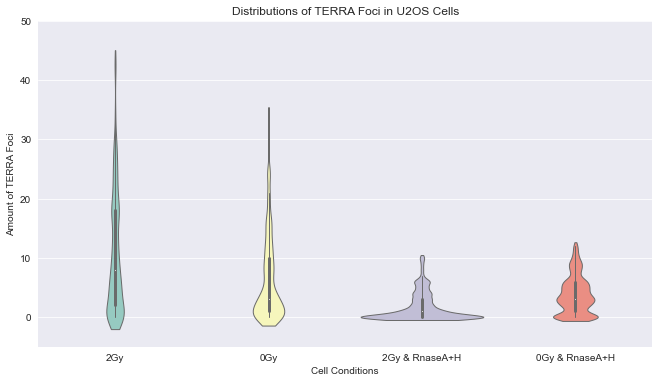

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=global_df, palette="Set3", bw=.2, cut=1, linewidth=1)

# Finalize the figure
ax.set(ylim=(-5, 50),xlabel= "Cell Conditions", ylabel="Amount of TERRA Foci")
sns.despine(left=True, bottom=True)
plt.title('Distributions of TERRA Foci in U2OS Cells')
### Try to see if it can be truncated at 0 ###

 It might be better to just show the violin plot, too much squeeze for the juice. Though, we do see a reinforcement of what is shown:
 - 2Gy very spread-out, with the maximum foci/cell being much higher than other conditions
 - 0Gy is morre spreead than the +RNAseA+H cells, but the maximum is not as high as the 2Gy
 - 2Gy & RNAseA+H are strongly clusteeres around 0 foci/cell, with a very low maximum
 - 0Gy & RNAseA+H are more distributed than the 2Gy & RNAseA+H Cells, but farr less than the -RNAseA+H cells. The middle seems to be around 5 foci/cell

## Bar Plot

In [15]:
#Creating a df for the TEERRA Foci means of each cell condition 

#global_df.mean() to find the means
mean_global_df = pd.DataFrame({'2Gy':[10.428571], '0Gy': [6.386555],
                               '2Gy & RnaseA+H': [1.705882], '0Gy & RnaseA+H':[ 3.747899]
                                })

#transpose and rename the df so that a barplot can be used
mean_global_df = mean_global_df.T
mean_global_df.columns = ['Mean TERRA Foci Amounts']

mean_global_df.head()

,Mean TERRA Foci Amounts
2Gy,10.428571
0Gy,6.386555
2Gy & RnaseA+H,1.705882
0Gy & RnaseA+H,3.747899


Text(0.5, 1.0, 'Mean Amount of TERRA Foci')

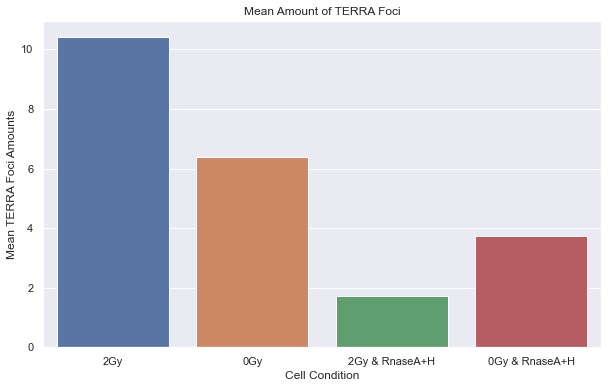

In [16]:
#x= mean_global_df.columns

plt.figure(figsize=(10,6))
ax = sns.set(font_scale=1)
ax = sns.barplot(x=mean_global_df.index, y='Mean TERRA Foci Amounts',
                 data=mean_global_df)

ax.set(xlabel='Cell Condition')
plt.title('Mean Amount of TERRA Foci')

## Do a box & whisker plot to show same thing but on one graph w/violin? ##
## No Error bars b/c only one value in the df ##
## Add stat significance ##

 It might be better to just show the violin plot, too much squeeze for the juice. Though, we do see a reinforcement of what is shown:
 - 2Gy Highest Foci/cell by far
 - 0Gy 2nd highest, but we shall see what the stats say
 - 2Gy & RNAseA+H very low which is an interesting point
 - 0Gy & RNAseA+H between the two lower, a curious point?????

## Ridgeline Plot

In [17]:
#Getting anoter df so that the ridgeplot can work
ridge_global_df = pd.read_excel('../Documents/global_DSB_TERRA.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    usecols = ['Distribution of TERRA Foci/Cell', 'Cell Condition']
                              )

ridge_global_df.set_index(['Distribution of TERRA Foci/Cell'])
ridge_global_df.dropna(axis=0, inplace=True) 

#ridge_global_df.columns
ridge_global_df.head()

,Distribution of TERRA Foci/Cell,Cell Condition
0,14,2Gy
1,24,2Gy
2,19,2Gy
3,43,2Gy
4,17,2Gy


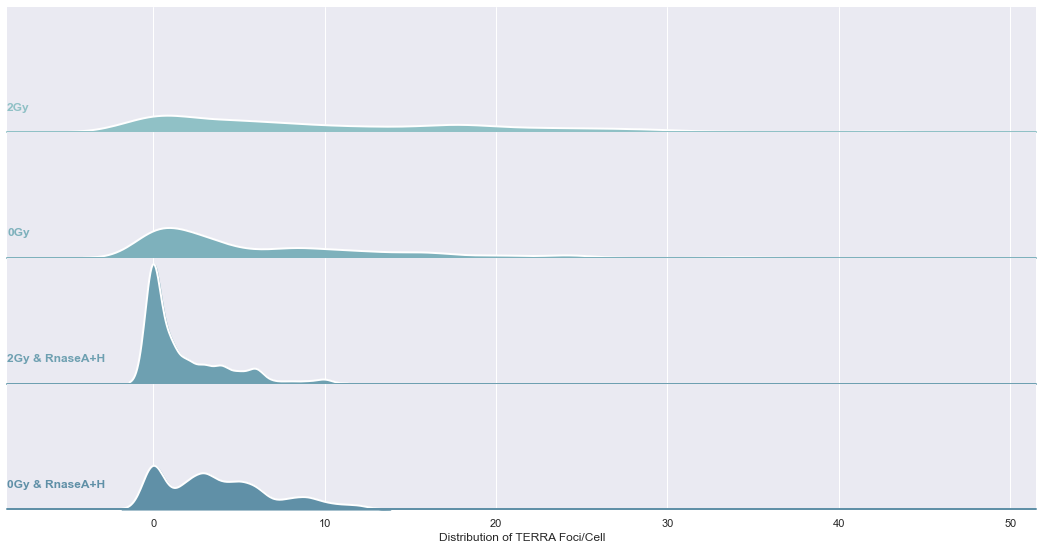

In [18]:
#Making the ridgeplot, special thanks to Seaborn for code help

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(ridge_global_df, row="Cell Condition", hue="Cell Condition", aspect=7.5, height=2, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Distribution of TERRA Foci/Cell",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Distribution of TERRA Foci/Cell", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Distribution of TERRA Foci/Cell")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

 It might be better to just show the violin plot, too much squeeze for the juice. Though, we do see a reinforcement of what is shown:
 - 2Gy very spread-out, with the maximum foci/cell being much higher than other conditions
 - 0Gy is morre spreead than the +RNAseA+H cells, but the maximum is not as high as the 2Gy
 - 2Gy & RNAseA+H are strongly clusteeres around 0 foci/cell, with a very low maximum
 - 0Gy & RNAseA+H are more distributed than the 2Gy & RNAseA+H Cells, but farr less than the -RNAseA+H cells. The middle seems to be around 5 foci/cell

# TERRA Locolizes to Telomeric DSBs
  - What the experiment is (e.g. what is it testing and how):
  - "To measure the colocalization of FLAG and TERRA  RNA FISH and Immunostaining to label FLAG in positively transfected cells and compare it to untransfected population."
  - to test wheather  this system allowed the formation of telomeric DSBs, cells were  fixed and immunostained to detect
    - a.FLAG  ( to label the positvely transfected cells).
    - b. yH2AX ( DSBs marker)
    - c. Edu ( S phase marker) FUCCI marker (G2 marker). 
    - The fixed cells were also stained with G-rich labeld PNA probe  to detect Telomeres (C-rich strands).


## Paired Box Plot

In [19]:
telo_df.head()
telo_df.columns

Index(['Cell_condition', 'Colocolization', 'total_foci', 'foci_per_cell'], dtype='object')

Text(0.5, 1.0, 'Average Total Cololocolized Foci')

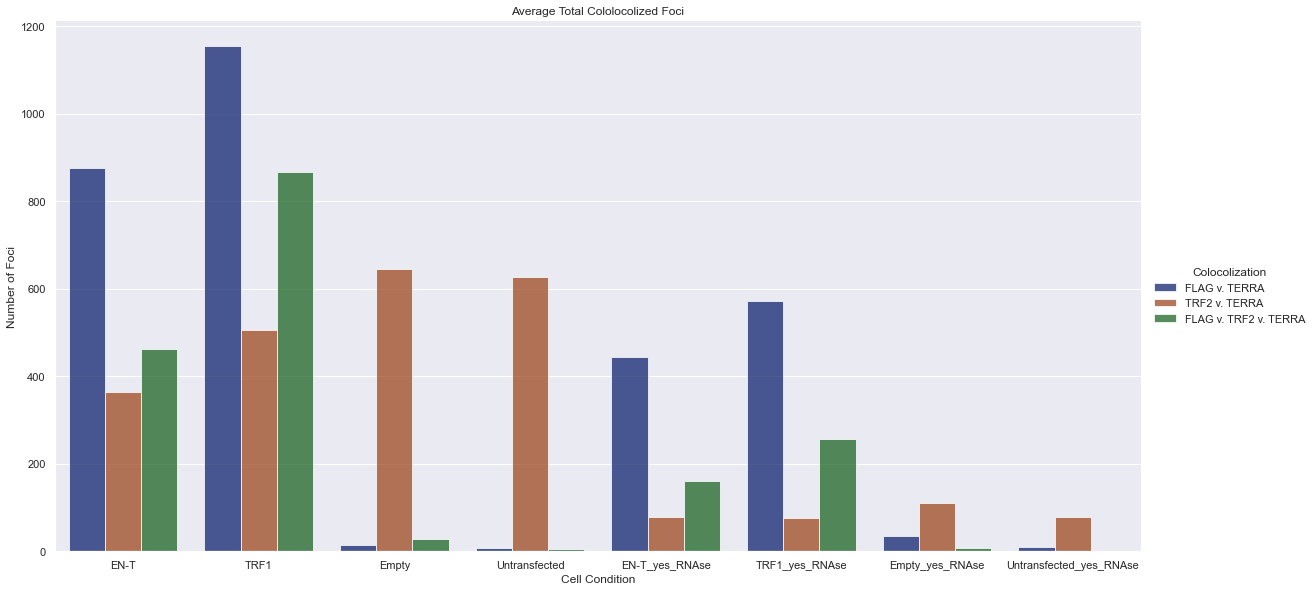

In [20]:
# Catagorical bar plot for percent of cells per phase
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="total_foci", hue="Colocolization",
    ci="sd", palette="dark", alpha=.75, height=8, aspect=2
)

g.despine(left=False)
g.set_axis_labels("Cell Condition", "Number of Foci")
g.legend.set_title("Colocolization")
plt.title("Average Total Cololocolized Foci")

Text(0.5, 1.0, 'Average Cololocolized Foci Per Cell')

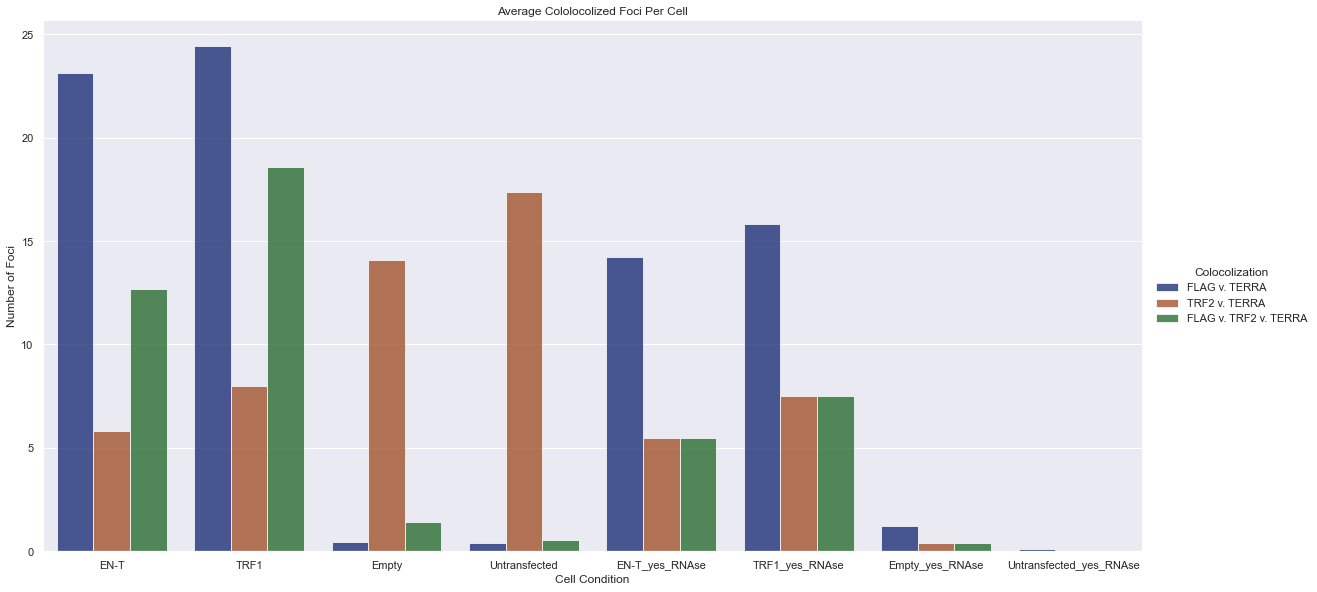

In [21]:
# Catagorical bar plot for percent of cells per phase
g = sns.catplot(
    data=telo_df, kind="bar",
    x="Cell_condition", y="foci_per_cell", hue="Colocolization",
    ci="sd", palette="dark", alpha=.75, height=8, aspect=2
)

g.despine(left=False)
g.set_axis_labels("Cell Condition", "Number of Foci")
g.legend.set_title("Colocolization")
plt.title("Average Cololocolized Foci Per Cell")

## Distributions

Text(0, 2.05, 'Distributions of TERRA Colocolizations')

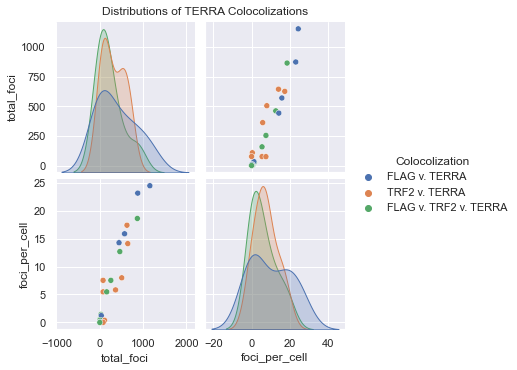

In [84]:
sns.pairplot(telo_df, hue="Colocolization", aspect=1)
plt.title("Distributions of TERRA Colocolizations", x=0, y=2.05)
#plt.legend(bbox_to_anchor=(2.01, 5),
           #borderaxespad=0)

Text(0, 2.05, 'Distributions of TERRA Colocolizations')

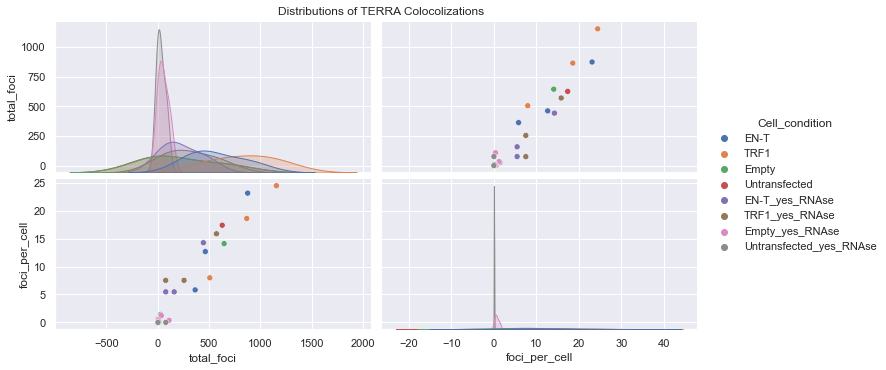

In [73]:
sns.pairplot(telo_df, hue="Cell_condition", aspect=2)
plt.title('Distributions of TERRA Colocolizations', x=0, y=2.05)

sns.pairplot(telo_all_df, hue="Cell_condition", aspect=1)
plt.title('Distributions of TERRA Colocolizations')

#### maybe box & whicker or vi0lin? ###
what is the most important thing to get across?

# TERRA locolization to Telomeric DSBs accumulated in the G2 phase of the cell cycle
  - Same experiment but assesed based on cells transfected with:
      - "G1 (stained  ONLY  with DAPI), in S phase (stained with DAPI+EdU) and G2 ( cells stained with green FUCCI and DAPI) and then compared this to the number of TERRA foci in untransfected control."
      - "To measure the colocalization of FLAG and TERRA  RNA FISH and Immunostaining to label FLAG in positively transfected cells and compare it to untransfected population."
      - to test wheather  this system allowed the formation of telomeric DSBs, cells were  fixed and immunostained to detect
        - a.FLAG  ( to label the positvely transfected cells).
        - b. yH2AX ( DSBs marker)
        - c. Edu ( S phase marker) FUCCI marker (G2 marker). 
        - The fixed cells were also stained with G-rich labeld PNA probe  to detect Telomeres (C-rich strands).

## Paired Box Plots

### see if we can do a total thing to show that G2 - some sort of scatter ##

In [24]:
g2_bar_cellper_df.head(6)

,Cell_condition,Phase,Cell_%_In_Phase
0,EN-T,G1,19.189511
1,EN-T,S,15.256257
2,EN-T,G2,65.554231
3,TRF1,G1,16.647264
4,TRF1,S,9.429569
5,TRF1,G2,73.923166


Text(0.5, 1.0, 'Percent of Cells per Phase')

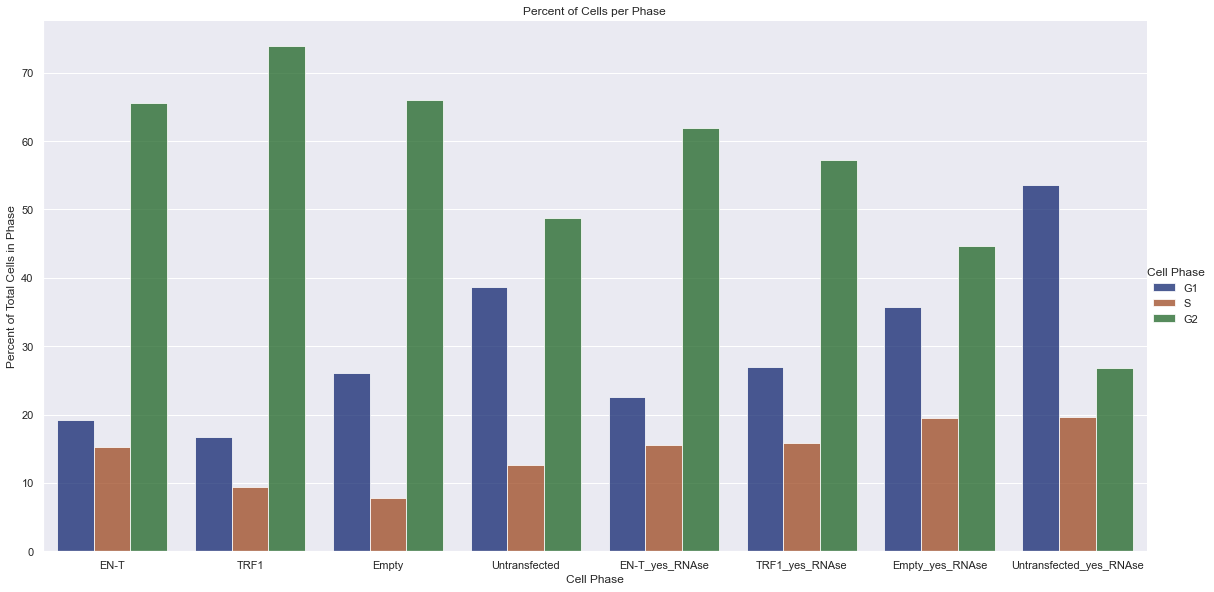

In [25]:
# Catagorical bar plot for percent of cells per phase
g = sns.catplot(
    data=g2_bar_cellper_df, kind="bar",
    x="Cell_condition", y="Cell_%_In_Phase", hue="Phase",
    ci="sd", palette="dark", alpha=.75, height=8, aspect=2
)

g.despine(left=False)
g.set_axis_labels("Cell Phase", "Percent of Total Cells in Phase")
g.legend.set_title("Cell Phase")
plt.title("Percent of Cells per Phase")

In [26]:
g2_bar_TERRAper_df.head(6)

,Cell_condition,Phase,TERRA_%_In_Phase
0,EN-T,G1,18.104772
1,EN-T,S,19.965608
2,EN-T,G2,61.929620
3,TRF1,G1,17.160728
4,TRF1,S,12.720786
5,TRF1,G2,70.118487


Text(0.5, 1.0, 'Percent of TERRA per Phase')

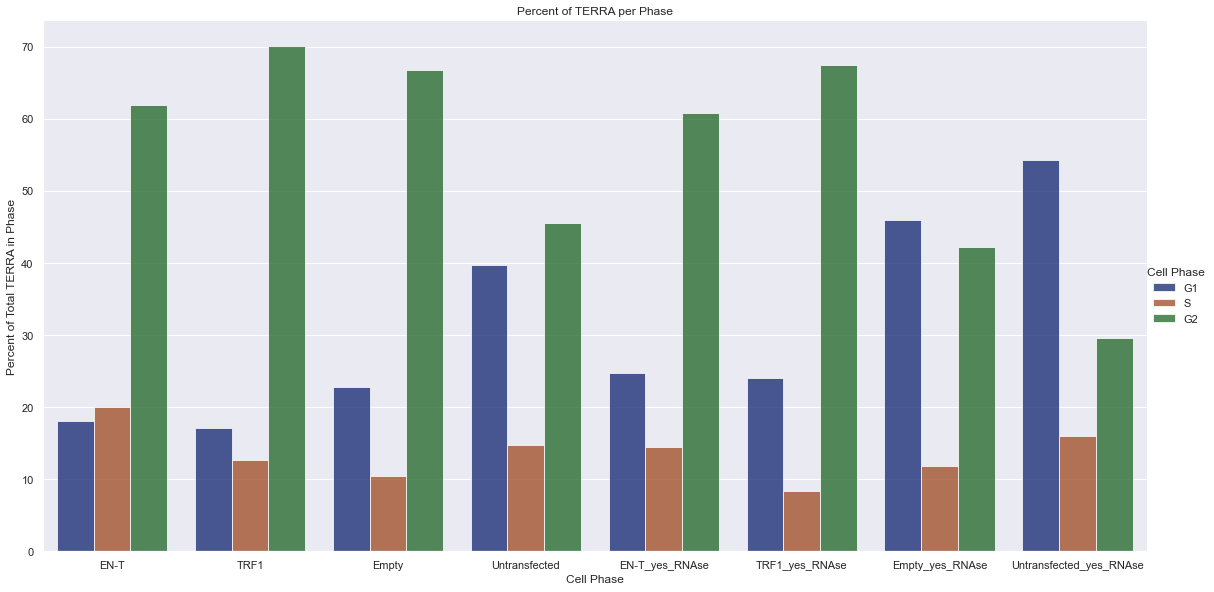

In [27]:
# Catagorical bar plot for percent of TERRA per phase
g = sns.catplot(
    data=g2_bar_TERRAper_df, kind="bar",
    x="Cell_condition", y="TERRA_%_In_Phase", hue="Phase",
    ci="sd", palette="dark", alpha=.75, height=8, aspect=2
)

g.despine(left=False)
g.set_axis_labels("Cell Phase", "Percent of Total TERRA in Phase")
g.legend.set_title("Cell Phase")
plt.title("Percent of TERRA per Phase")

From the paired box plots, we can determine the following:
 - Cells accumulated in G2 unless they were untransfected with RNAse
 - TERRA Accumulated in G2 unless empty w/ RNAse or Untransfected w/ RNAse
 - S phase consitently showed the least accumulation 

My thoughts:
 - We can safely say that both cells and TERRA accumulate in G2
 - I'm currious when TERRA jumps on. I.e. it could just be there along for the ride and then the G2 checkpoint just stops all from passing on
 - I think some more consideration needs to go into the mechanisms: i.e. what signals are at play 
 
***Look at the experimental protocol to see what we can and cannot say***

## Distributions

In [28]:
g2_phase_combo_df.head(6)

,Cell_condition,Phase,TERRA_%_In_Phase,Cell_%_In_Phase
0,EN-T,G1,18.104772,19.189511
1,EN-T,S,19.965608,15.256257
2,EN-T,G2,61.929620,65.554231
3,TRF1,G1,17.160728,16.647264
4,TRF1,S,12.720786,9.429569
5,TRF1,G2,70.118487,73.923166


Text(-3, 1.25, 'Percent of Cell vs. Percent of TERRA Per Phase')

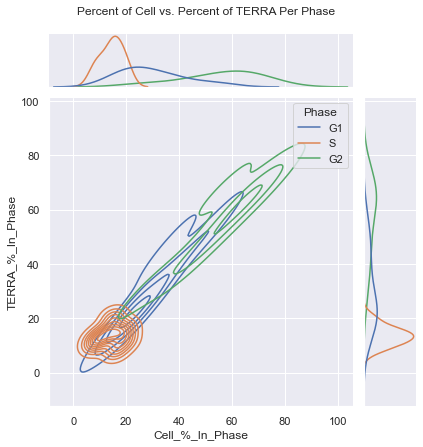

In [100]:
# Show that both the majority percent of cells and percent of TERRA accumulate in G2
g = sns.jointplot(
    data=g2_phase_combo_df,
    x="Cell_%_In_Phase", y="TERRA_%_In_Phase", hue="Phase",
    kind="kde",
)

plt.title('Percent of Cell vs. Percent of TERRA Per Phase', x=-3, y=1.25)

Text(-3, 1.25, 'Percent of Cell vs. Percent of TERRA Depending on Cell Condition')

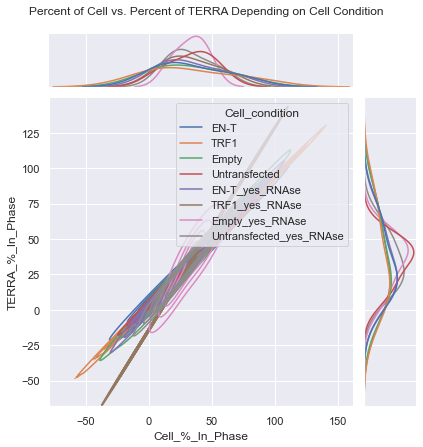

In [101]:
# Show that the accunulation in G2 is independent of the cell condition
g = sns.jointplot(
    data=g2_phase_combo_df,
    x="Cell_%_In_Phase", y="TERRA_%_In_Phase", hue="Cell_condition",
    kind="kde",
)

plt.title('Percent of Cell vs. Percent of TERRA Depending on Cell Condition', x=-3, y=1.25)


In [31]:
g2_all_combo_df.head(6)

,Cell_condition,Phase,TERRA_%_In_Phase,Cell_%_In_Phase,Cell_Amount,TERRA_Amount
0,EN-T,G1,18.104772,19.189511,16.1,294.8
1,EN-T,S,19.965608,15.256257,12.8,325.1
2,EN-T,G2,61.929620,65.554231,55.0,1008.4
3,TRF1,G1,17.160728,16.647264,14.3,389.6
4,TRF1,S,12.720786,9.429569,8.1,288.8
5,TRF1,G2,70.118487,73.923166,63.5,1591.9


Text(-1, 4.15, 'TERRA and Cell Metrics Distributed Based On Cell Phase')

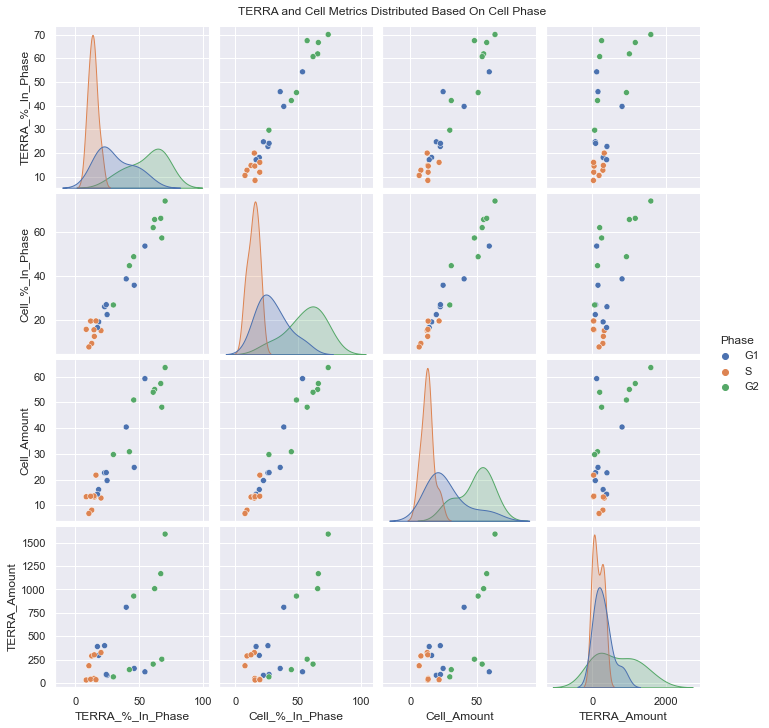

In [66]:
sns.pairplot(g2_all_combo_df, hue="Phase", aspect=1)
plt.title('TERRA and Cell Metrics Distributed Based On Cell Phase', x=-1, y=4.15)

Text(-1, 4.15, 'TERRA and Cell Metrics Distributed Based On Cell Condition')

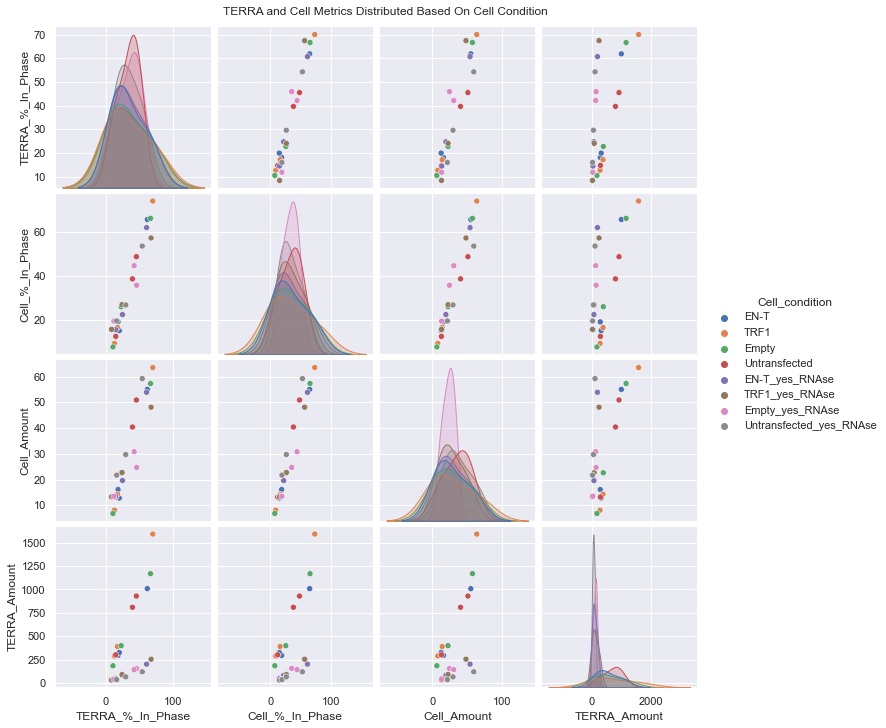

In [68]:
sns.pairplot(g2_all_combo_df, hue="Cell_condition", aspect=1)
plt.title('TERRA and Cell Metrics Distributed Based On Cell Condition',x=-1, y=4.15)

***could use full data to make them stronger? Or at least put in the word "average" in places***
***Can "weigh" the points to show the proportion of cells/TERRA to make G2 heavier? - show that seperation?***

What we can deduce from the distribution plots:
- S phase had the least amount of accumulated cells and TERRA
- G1 Had the middle most accumulation
- G2 had the most accumulation
- There was some varience, but the peaks don't lie
- Cell cycle accumulation is independent from the cell condiditon for the most part

My thoughts:
- Some cells are getting stuck at G1 checkpoint
- Very few cells get stuck at S checkpoint
- The great majority of cells are getting stuck at G2 checkpoint
- Look at lit to see if there is a telomeric signal at the G2 checkpoint


# Conclusions 